## Equation 
The equation we are testing is

$$
\begin{cases}
u''(x) +u(x) = e^{-x}, \qquad\text{for}\; 0<x<1,\\
u(0) = 1,  \qquad u\left(1\right) = \frac{1}{2}\cos(1) + \frac{1}{2}\sin(1) + \frac{e^{-1}}{2}.
\end{cases}
$$ 

The exact solution is
$$ u^*(x) = \frac{\cos x+\sin x + e^{-x}}{2} $$



---

The idea of the paper is, assume $$u = \mathrm{NN}(x).$$
We minimize the loss function
$$ L(u^*, \hat{u}) = \mathrm{Mean}\left(\left\Vert \frac{d^2\hat{u}}{dx^2} + \hat{u}(x) - \Big(- e^{x}\Big)\right\Vert^2\right) + \frac{|\hat{u}(0)|^2 + |\hat{u}\left(1\right)|^2}{2}$$
where all the derivatives are computed via 
* back-propagation - we tried this idea but it does not work well, maybe autograd in Pytorch does not perform it well, or the idea behind it is problematic, in the sense that the derivative obtained by back-propagation with second-order is not very nice.
* finite difference scheme

In [1]:
# Import libraries
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import math
import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [2]:
def u_star_func(x):
    result = 1/2*(np.exp(-x) + np.cos(x) + np.sin(x))
    return result

In [3]:
input_size = 1
output_size = 1
k = 32

model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, output_size),
                      nn.Tanh(),
                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=1, bias=True)
  (7): Tanh()
)


In [4]:
import matplotlib.pyplot as plt
def draw_result(lst_iter, lst_loss, title='Loss'):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title +".png")  # should before show method

    # show
    plt.show()

In [5]:
def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true solution')
    plt.plot(lst_iter, lst_acc, '-r', label='PINNs')

    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method

    # show
    plt.show()

## Backpropagation

In [6]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init_np = x_init_np[1:-1]
x_init = torch.tensor(x_init_np, requires_grad= True)

The running loss at 0 iteration is: 7.790152072906494
The running loss at 1 iteration is: 6.060596466064453
The running loss at 2 iteration is: 4.765223979949951
The running loss at 3 iteration is: 3.968010663986206
The running loss at 4 iteration is: 3.582139015197754
The running loss at 5 iteration is: 3.4075286388397217
The running loss at 6 iteration is: 3.300382137298584
The running loss at 7 iteration is: 3.177750825881958
The running loss at 8 iteration is: 3.012901782989502
The running loss at 9 iteration is: 3.034736156463623
The running loss at 10 iteration is: 3.1416876316070557
The running loss at 11 iteration is: 3.1392111778259277
The running loss at 12 iteration is: 3.0453503131866455
The running loss at 13 iteration is: 2.9062588214874268
The running loss at 14 iteration is: 2.9566874504089355
The running loss at 15 iteration is: 3.032621383666992
The running loss at 16 iteration is: 2.9962759017944336
The running loss at 17 iteration is: 2.896069049835205
The running l

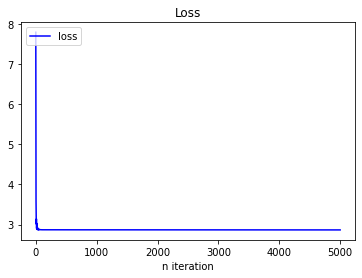

The running loss at 5000 iteration is: 2.8685202598571777


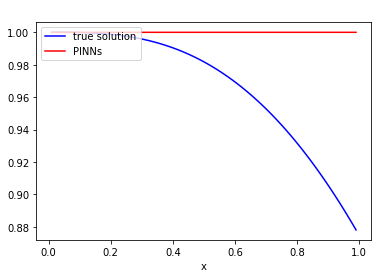

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
time0 = time()
num_e = 5000
iter = []
test_error_vec = []
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=0.1)

for e in range(num_e):
    running_loss = 0
    optimizer.zero_grad() 
    u_hat = torch.tensor(np.array([]))
    du_dx = torch.tensor(np.array([]))
    du2_dx2 = torch.tensor(np.array([]))
    for xi in x_init_np:
        x_tensor = torch.tensor([xi], requires_grad=True)
        temp = model(x_tensor.float())
        u_hat = torch.hstack([u_hat, temp])
        first_deri = autograd.grad(model(x_tensor.float()), x_tensor, create_graph=True)[0]
        du_dx = torch.hstack([du_dx, first_deri])
        second_derivative = autograd.grad(first_deri, x_tensor)[0]
        du2_dx2 = torch.hstack([du2_dx2, second_derivative])
    tensor1 = torch.tensor([1.])
    loss = torch.mean((du2_dx2 + u_hat - torch.exp(x_tensor))**2) +  (model(torch.tensor([0.])-1))**2/2.
    loss += (model(tensor1)-torch.cos(tensor1)/2. - torch.sin(tensor1)/2. - torch.exp(torch.tensor([-1.]))/2.)**2/2.
    loss.backward()
    optimizer.step() 
    scheduler2.step()

    running_loss += loss.clone().item()    
    
    print(f"The running loss at {e} iteration is: {running_loss}")
    test_error_vec.append(running_loss)
    iter.append(e)

draw_result(iter, test_error_vec)
print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")
y_true = u_star_func(x_init_np)
draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), ' ')

In [8]:
u_hat

tensor([0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       dtype=torch.float64, grad_fn=<CatBackward0>)

In [9]:
torch.mean(u_hat), torch.var(u_hat)

(tensor(1.0000, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(2.2672e-11, dtype=torch.float64, grad_fn=<VarBackward0>))

In [10]:
du_dx

tensor([7.8722e-05, 7.4665e-05, 7.0892e-05, 6.7385e-05, 6.4056e-05, 6.0895e-05,
        5.7959e-05, 5.5231e-05, 5.2637e-05, 5.0171e-05, 4.7881e-05, 4.5702e-05,
        4.3628e-05, 4.1703e-05, 3.9869e-05, 3.8168e-05, 3.6545e-05, 3.4998e-05,
        3.3522e-05, 3.2114e-05, 3.0809e-05, 2.9562e-05, 2.8371e-05, 2.7233e-05,
        2.6179e-05, 2.5170e-05, 2.4205e-05, 2.3282e-05, 2.2399e-05, 2.1553e-05,
        2.0743e-05, 1.9994e-05, 1.9276e-05, 1.8587e-05, 1.7927e-05, 1.7293e-05,
        1.6686e-05, 1.6102e-05, 1.5543e-05, 1.5026e-05, 1.4509e-05, 1.4032e-05,
        1.3574e-05, 1.3115e-05, 1.2691e-05, 1.2284e-05, 1.1892e-05, 1.1515e-05,
        1.1152e-05, 1.0802e-05, 1.0480e-05, 1.0156e-05, 9.8430e-06, 9.5553e-06,
        9.2647e-06, 8.9846e-06, 8.7270e-06, 8.4663e-06, 8.2267e-06, 7.9953e-06,
        7.7609e-06, 7.5454e-06, 7.3373e-06, 7.1363e-06, 6.9321e-06, 6.7447e-06,
        6.5635e-06, 6.3884e-06, 6.2190e-06, 6.0553e-06, 5.8969e-06, 5.7437e-06,
        5.5955e-06, 5.4520e-06, 5.3132e-

In [11]:
torch.mean(du2_dx2), torch.var(du2_dx2)

(tensor(-7.8630e-05, dtype=torch.float64),
 tensor(9.5291e-09, dtype=torch.float64))

In [12]:
(model(torch.tensor([0.])-1))**2/2.

tensor([7.9741e-12], grad_fn=<DivBackward0>)

In [13]:
(model(torch.tensor([0.])-1))

tensor([3.9935e-06], grad_fn=<TanhBackward0>)

In [14]:
 (model(tensor1)-torch.cos(tensor1)/2. - torch.sin(tensor1)/2. - torch.exp(torch.tensor([-1.]))/2.)**2/2.

tensor([0.0078], grad_fn=<DivBackward0>)

In [15]:
 (model(tensor1)-torch.cos(tensor1)/2. - torch.sin(tensor1)/2. - torch.exp(torch.tensor([-1.]))/2.)

tensor([0.1251], grad_fn=<SubBackward0>)

## Finite difference

In [ ]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init = torch.tensor(x_init_np, requires_grad= True)

input_size = 1
output_size = 1
k = 16#32

model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, output_size),
                      nn.Tanh(),
                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Tanh()
)


In [ ]:
bb = u_star_func(1)
y_true = u_star_func(x_init_np)

def run_train(lr = 0.001, num_e = 1000, isOn = True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    time0 = time()
    num_e = num_e
    iter = []
    test_error_vec = []
    # scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1)
    # scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    for e in range(num_e):
        # running_loss = 0
        
        optimizer.zero_grad() # call zero_Grad
        # u_hat = model(xtensor.float())
        u_hat = torch.tensor(np.array([])) 
        d2u_hat = torch.tensor(np.array([]))
        for x in x_init_np:
            x_tensor = torch.tensor(np.array([x]), requires_grad= True)
            temp = model(x_tensor.float())
            u_hat = torch.hstack([u_hat, temp])

        loss = 1/2*(torch.square(u_hat[0]-1) + torch.square(u_hat[-1]-bb))
        u_hat[0] = 1
        u_hat[-1] = bb   
        d2u_hat = u_hat.clone()    
        d2u_hat[1:-1] = (u_hat[0:-2] + u_hat[2:] - 2*u_hat[1:-1])/step**2      
        loss = loss + torch.mean((d2u_hat[1:-1] +u_hat[1:-1]- torch.exp(-x_init[1:-1]))**2) 
        loss.backward()
      
        optimizer.step() 

        running_loss = loss.clone().item()    
        if isOn == True:
            print(f"The running loss at {e+1} iteration is: {running_loss}")
        test_error_vec.append(running_loss)
        iter.append(e)

        if e%500 ==0:
          draw_result(iter, test_error_vec)
          draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), ' ')
          print("MSE predicted vs true at", e+1, "iteration", np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))


    draw_result(iter, test_error_vec)
    draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), ' ')
    print(np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))

The running loss at 1 iteration is: 951515.8882905032


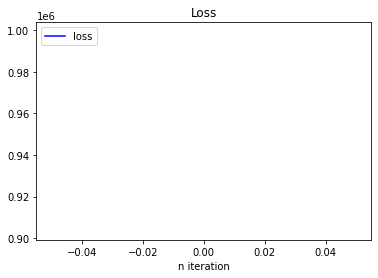

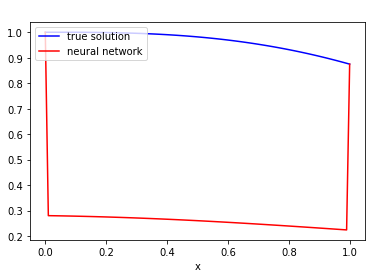

MSE predicted vs true at 1 iteration 0.4935153759376228
The running loss at 2 iteration is: 502959.77466823236
The running loss at 3 iteration is: 236800.07943251915
The running loss at 4 iteration is: 101343.5197072247
The running loss at 5 iteration is: 41744.041109298516
The running loss at 6 iteration is: 18426.52705097438
The running loss at 7 iteration is: 10273.961486243408
The running loss at 8 iteration is: 7964.478798036765
The running loss at 9 iteration is: 7773.256693910976
The running loss at 10 iteration is: 8278.340688873255
The running loss at 11 iteration is: 8951.875151423164
The running loss at 12 iteration is: 9606.93504486925
The running loss at 13 iteration is: 10185.723217101384
The running loss at 14 iteration is: 10678.168378879514
The running loss at 15 iteration is: 11090.820693900485
The running loss at 16 iteration is: 11434.728256665068
The running loss at 17 iteration is: 11721.094468095616
The running loss at 18 iteration is: 11959.799234399401
The runn

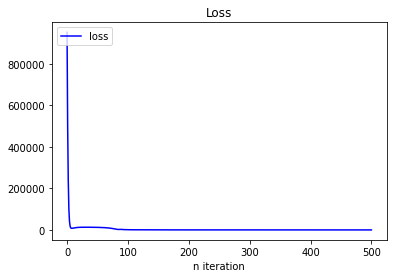

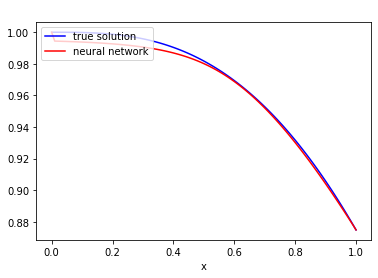

MSE predicted vs true at 501 iteration 1.3544850698610506e-05
The running loss at 502 iteration is: 31.061870431195157
The running loss at 503 iteration is: 30.967145167033692
The running loss at 504 iteration is: 30.873888180453275
The running loss at 505 iteration is: 30.78010314030015
The running loss at 506 iteration is: 30.685777925297494
The running loss at 507 iteration is: 30.592926782575553
The running loss at 508 iteration is: 30.500896345919713
The running loss at 509 iteration is: 30.408994073484052
The running loss at 510 iteration is: 30.317252827071663
The running loss at 511 iteration is: 30.22629357410399
The running loss at 512 iteration is: 30.136121557262403
The running loss at 513 iteration is: 30.04609161559491
The running loss at 514 iteration is: 29.956862625373155
The running loss at 515 iteration is: 29.867748126512947
The running loss at 516 iteration is: 29.77811269276128
The running loss at 517 iteration is: 29.68993210849584
The running loss at 518 iterati

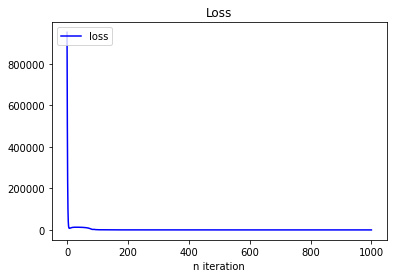

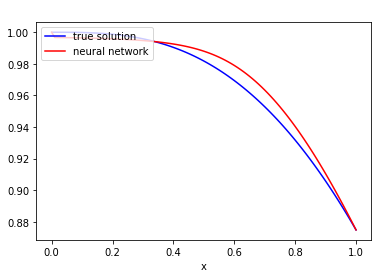

MSE predicted vs true at 1001 iteration 3.6636836348552004e-05
The running loss at 1002 iteration is: 10.89254440398376
The running loss at 1003 iteration is: 10.875618898864502
The running loss at 1004 iteration is: 10.859101278607781
The running loss at 1005 iteration is: 10.842988521693563
The running loss at 1006 iteration is: 10.82610543663786
The running loss at 1007 iteration is: 10.80962319541418
The running loss at 1008 iteration is: 10.793546592611264
The running loss at 1009 iteration is: 10.776699149554638
The running loss at 1010 iteration is: 10.760653525218205
The running loss at 1011 iteration is: 10.744222558247072
The running loss at 1012 iteration is: 10.728197019606817
The running loss at 1013 iteration is: 10.711791898242103
The running loss at 1014 iteration is: 10.69579021972638
The running loss at 1015 iteration is: 10.679414404963888
The running loss at 1016 iteration is: 10.66383111013347
The running loss at 1017 iteration is: 10.647472620762878
The running lo

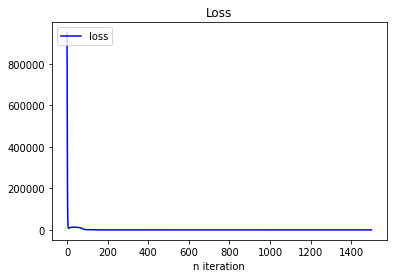

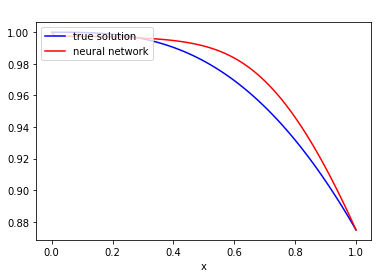

MSE predicted vs true at 1501 iteration 8.610741696828989e-05
The running loss at 1502 iteration is: 5.775139972457353
The running loss at 1503 iteration is: 5.769182345060776
The running loss at 1504 iteration is: 5.762942653985983
The running loss at 1505 iteration is: 5.756709392016796
The running loss at 1506 iteration is: 5.750480432209722
The running loss at 1507 iteration is: 5.744252132068244
The running loss at 1508 iteration is: 5.738028081468072
The running loss at 1509 iteration is: 5.732093668340967
The running loss at 1510 iteration is: 5.725876183959867
The running loss at 1511 iteration is: 5.719661390611283
The running loss at 1512 iteration is: 5.713451360822056
The running loss at 1513 iteration is: 5.70781606144082
The running loss at 1514 iteration is: 5.70161303679734
The running loss at 1515 iteration is: 5.695412165351777
The running loss at 1516 iteration is: 5.689212965458426
The running loss at 1517 iteration is: 5.6835888303176185
The running loss at 1518 it

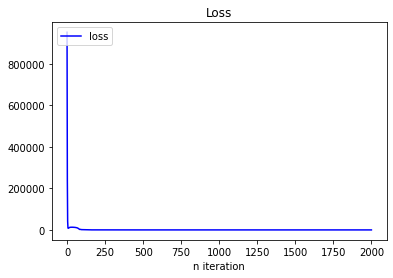

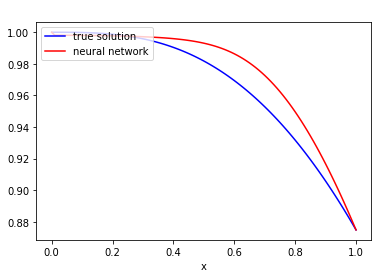

MSE predicted vs true at 2001 iteration 0.00012741869226224283
The running loss at 2002 iteration is: 3.591493194803378
The running loss at 2003 iteration is: 3.588399623651588
The running loss at 2004 iteration is: 3.5853103621998974
The running loss at 2005 iteration is: 3.582226645884546
The running loss at 2006 iteration is: 3.5791430201638885
The running loss at 2007 iteration is: 3.57650571601813
The running loss at 2008 iteration is: 3.573418943707123
The running loss at 2009 iteration is: 3.570342017032949
The running loss at 2010 iteration is: 3.567263387325582
The running loss at 2011 iteration is: 3.564184828216522
The running loss at 2012 iteration is: 3.561106062999819
The running loss at 2013 iteration is: 3.558478904415004
The running loss at 2014 iteration is: 3.5554045802161833
The running loss at 2015 iteration is: 3.552333946634363
The running loss at 2016 iteration is: 3.549036826590559
The running loss at 2017 iteration is: 3.5464154254043416
The running loss at 20

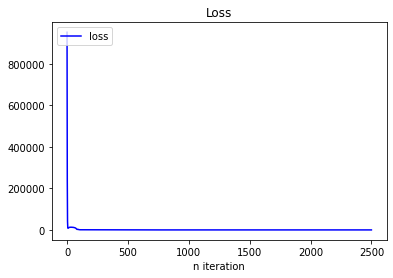

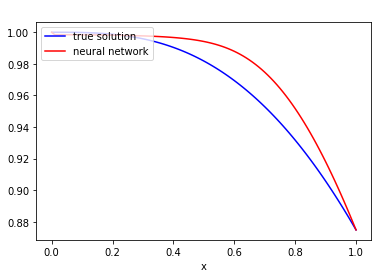

MSE predicted vs true at 2501 iteration 0.00015559676816150495
The running loss at 2502 iteration is: 2.4386465882611006
The running loss at 2503 iteration is: 2.4368465433520186
The running loss at 2504 iteration is: 2.435042772089685
The running loss at 2505 iteration is: 2.4334263379809946
The running loss at 2506 iteration is: 2.431630881940188
The running loss at 2507 iteration is: 2.429830476770791
The running loss at 2508 iteration is: 2.42839542453363
The running loss at 2509 iteration is: 2.426603443749856
The running loss at 2510 iteration is: 2.424623628498889
The running loss at 2511 iteration is: 2.4231850492254763
The running loss at 2512 iteration is: 2.4213927493307064
The running loss at 2513 iteration is: 2.4194132160385178
The running loss at 2514 iteration is: 2.4179830610524022
The running loss at 2515 iteration is: 2.4161938034687656
The running loss at 2516 iteration is: 2.4143971352586457
The running loss at 2517 iteration is: 2.4127900519107333
The running loss

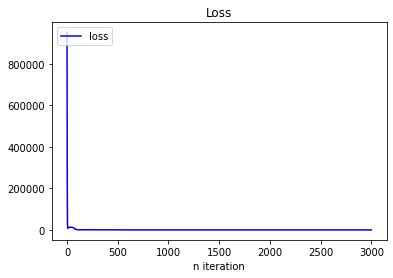

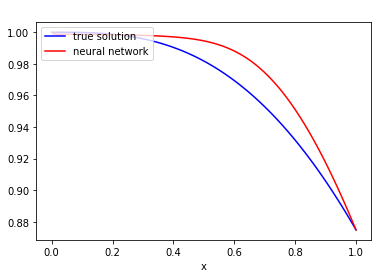

MSE predicted vs true at 3001 iteration 0.00015268921717623803
The running loss at 3002 iteration is: 1.7522881978229743
The running loss at 3003 iteration is: 1.7510475755339032
The running loss at 3004 iteration is: 1.7499832412432033
The running loss at 3005 iteration is: 1.7487500319573583
The running loss at 3006 iteration is: 1.7476841516691526
The running loss at 3007 iteration is: 1.7464694234837688
The running loss at 3008 iteration is: 1.7454037363072346
The running loss at 3009 iteration is: 1.7445035945208518
The running loss at 3010 iteration is: 1.7431241151505636
The running loss at 3011 iteration is: 1.7422184208486613
The running loss at 3012 iteration is: 1.740840217597109
The running loss at 3013 iteration is: 1.7399313878566232
The running loss at 3014 iteration is: 1.738556350466384
The running loss at 3015 iteration is: 1.7374961789688985
The running loss at 3016 iteration is: 1.7365891811171175
The running loss at 3017 iteration is: 1.735221507195949
The running 

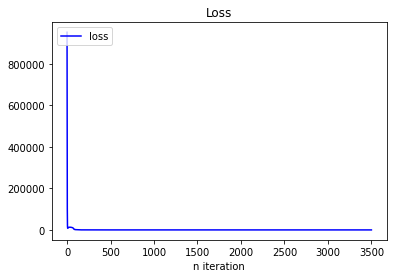

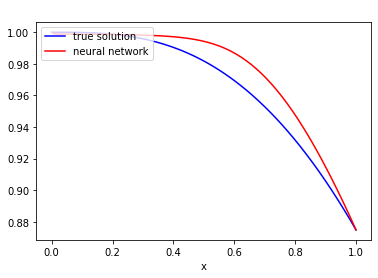

MSE predicted vs true at 3501 iteration 0.00011950771846188175
The running loss at 3502 iteration is: 1.308441002257794
The running loss at 3503 iteration is: 1.3076364595197143
The running loss at 3504 iteration is: 1.3067030653585523
The running loss at 3505 iteration is: 1.305918254789102
The running loss at 3506 iteration is: 1.3051507305132455
The running loss at 3507 iteration is: 1.304498827062345
The running loss at 3508 iteration is: 1.3034676186662264
The running loss at 3509 iteration is: 1.3026696364925168
The running loss at 3510 iteration is: 1.302028837269379
The running loss at 3511 iteration is: 1.3009542994731202
The running loss at 3512 iteration is: 1.3001686203789438
The running loss at 3513 iteration is: 1.2994996469098514
The running loss at 3514 iteration is: 1.2987136713963447
The running loss at 3515 iteration is: 1.297663828571227
The running loss at 3516 iteration is: 1.2968795923594694
The running loss at 3517 iteration is: 1.2962396026247345
The running lo

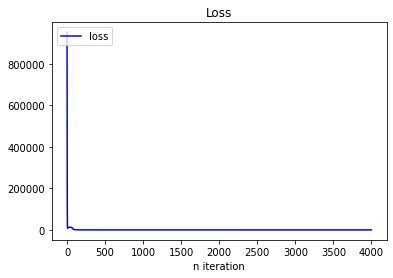

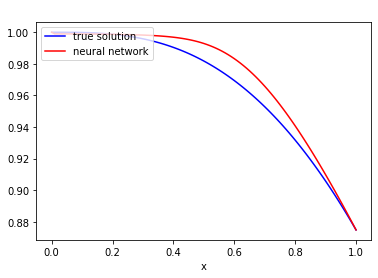

MSE predicted vs true at 4001 iteration 6.247798019948768e-05
The running loss at 4002 iteration is: 1.0477084959669472
The running loss at 4003 iteration is: 1.0494291798212048
The running loss at 4004 iteration is: 1.0484542929459673
The running loss at 4005 iteration is: 1.0450727049806114
The running loss at 4006 iteration is: 1.0426110131657873
The running loss at 4007 iteration is: 1.0429201626227276
The running loss at 4008 iteration is: 1.0438024318323809
The running loss at 4009 iteration is: 1.0432051282688055
The running loss at 4010 iteration is: 1.0411382399372957
The running loss at 4011 iteration is: 1.03923137178249
The running loss at 4012 iteration is: 1.038766182716588
The running loss at 4013 iteration is: 1.039059881880912
The running loss at 4014 iteration is: 1.0386588231484575
The running loss at 4015 iteration is: 1.0373423681143998
The running loss at 4016 iteration is: 1.0357890321348409
The running loss at 4017 iteration is: 1.0349293954118013
The running lo

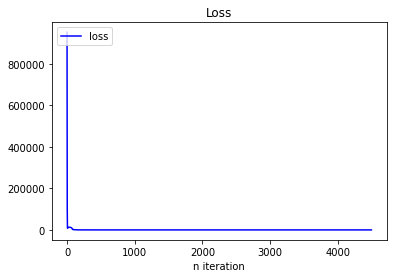

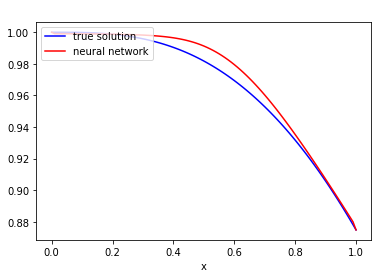

MSE predicted vs true at 4501 iteration 3.0379645382921704e-05
The running loss at 4502 iteration is: 4.8914926733156845
The running loss at 4503 iteration is: 2.348891362639837
The running loss at 4504 iteration is: 0.8865269992377242
The running loss at 4505 iteration is: 2.2926154179170695
The running loss at 4506 iteration is: 3.827269679049566
The running loss at 4507 iteration is: 2.698274507025769
The running loss at 4508 iteration is: 1.1018611056119745
The running loss at 4509 iteration is: 1.1700004113641929
The running loss at 4510 iteration is: 2.3036665036814163
The running loss at 4511 iteration is: 2.5418142057246254
The running loss at 4512 iteration is: 1.4413081304532258
The running loss at 4513 iteration is: 0.8894176264433497
The running loss at 4514 iteration is: 1.4644803286851447
The running loss at 4515 iteration is: 1.9434590199849915
The running loss at 4516 iteration is: 1.5829669836055877
The running loss at 4517 iteration is: 0.9546092922111393
The running 

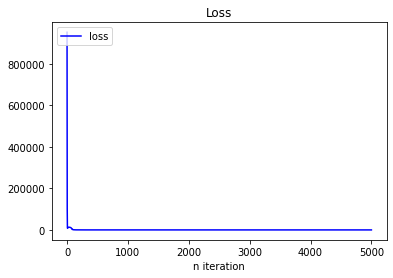

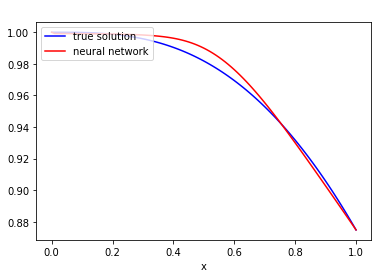

MSE predicted vs true at 5001 iteration 1.718691317103574e-05
The running loss at 5002 iteration is: 0.7301227453807841
The running loss at 5003 iteration is: 0.7295111893812383
The running loss at 5004 iteration is: 0.728986582124864
The running loss at 5005 iteration is: 0.7283771885171422
The running loss at 5006 iteration is: 0.727849538548126
The running loss at 5007 iteration is: 0.727340075571054
The running loss at 5008 iteration is: 0.7267151405682272
The running loss at 5009 iteration is: 0.7261979753823757
The running loss at 5010 iteration is: 0.7257728264510503
The running loss at 5011 iteration is: 0.7250691819506049
The running loss at 5012 iteration is: 0.7245471985967213
The running loss at 5013 iteration is: 0.7241228522572569
The running loss at 5014 iteration is: 0.7234192254772148
The running loss at 5015 iteration is: 0.7229957788336362
The running loss at 5016 iteration is: 0.7224798598131283
The running loss at 5017 iteration is: 0.7217673412245728
The running l

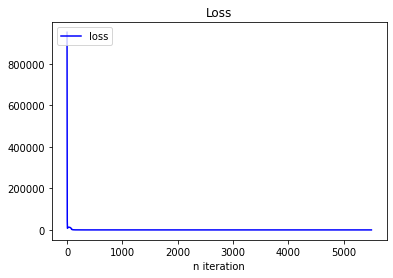

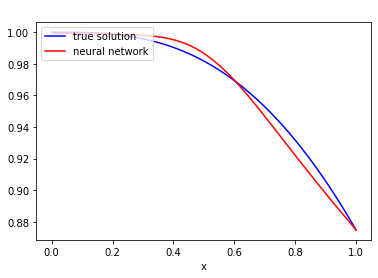

MSE predicted vs true at 5501 iteration 2.403250269950527e-05
The running loss at 5502 iteration is: 0.7003669515999469
The running loss at 5503 iteration is: 0.6995973071918968
The running loss at 5504 iteration is: 0.6990606592353664
The running loss at 5505 iteration is: 0.6984278640537726
The running loss at 5506 iteration is: 0.698153334362974
The running loss at 5507 iteration is: 0.6974141138947311
The running loss at 5508 iteration is: 0.6968975423953673
The running loss at 5509 iteration is: 0.6960971036539818
The running loss at 5510 iteration is: 0.6956884024424831
The running loss at 5511 iteration is: 0.695188836632146
The running loss at 5512 iteration is: 0.6946624790312441
The running loss at 5513 iteration is: 0.6940385563836908
The running loss at 5514 iteration is: 0.6934267298631533
The running loss at 5515 iteration is: 0.6928881591307825
The running loss at 5516 iteration is: 0.6923305207542705
The running loss at 5517 iteration is: 0.6918340607589675
The running 

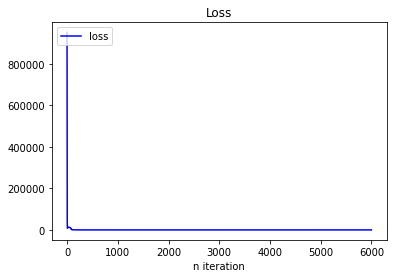

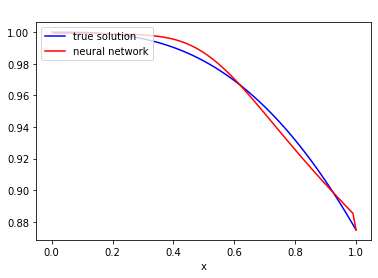

1.3460860443229628e-05


In [ ]:
run_train(lr=0.01, num_e= 6000)

In [ ]:
def evaluate_np(x_data_np):
    u_hat = []
    for x in x_data_np:
        x_tensor = torch.tensor(np.array([x]), requires_grad= True)
        temp = model(x_tensor.float())
        u_hat.append(temp.clone().item())
        # u_hat = torch.hstack([u_hat, temp])
    return u_hat

In [ ]:
def evaluate_error_np(x_data_np):
    y_pred = evaluate_np(x_data_np)
    y_true = u_star_func(x_data_np)
    return np.mean(np.square(y_true -  y_pred))

In [ ]:
x_init_np2 = np.arange(start=a, stop=b+step/2, step=step/2)
x_init2 = torch.tensor(x_init_np2, requires_grad= True)
y_pred2 = evaluate_np(x_init_np2)
# draw_result(x_init_np2, y_pred2, 'solution-NN')
evaluate_error_np(x_init_np2)

8.47118130704705e-05

In [ ]:
step_size = []
error = []
for k in [1,2,3,4,5,6,7]:
    x_vec = np.arange(start=a, stop=b+step/k, step=step/k)
    # x_vec_tensor = torch.tensor(x_vec, requires_grad= True)
    y_pred = evaluate_np(x_vec)
    error.append(evaluate_error_np(x_vec))
    step_size.append(step/k)